In [1]:
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import numpy as np
# Saving and type checking
import shutil
# Operators
import ufl
from ufl import TrialFunction, TestFunction,TrialFunctions,TestFunctions, FacetNormal, SpatialCoordinate
from ufl import dx, ds, exp, sym, tr, sqrt
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm


# Operators
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = Infix(ufl.dot)
inner = Infix(ufl.inner)


def vector(*args):
    return ufl.as_vector(tuple(args))


npor = Infix(np.logical_or)
npand = Infix(np.logical_and)


def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return ufl.Identity(func_like.geometric_dimension())


# Post processing:


def errors_L(space, uS, uEx):
    # Fix it for vectors
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = space.mesh

    L1_scalar = fem.assemble_scalar(fem.form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(fem.form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """Create graph from fem.Function

    Args:
        fig (plt.Figure): Figure
        lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
        method (bool): Graph method True = tripcolor, False = tricontourf
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        fig, ax = plt.subplots()
        plt.close()
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on: ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

        if natural_show:
            plot = ax.tripcolor(*data)
        else:
            try:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(
                    *data,
                    levels=levels,
                    )
            except:
                print(f'{title} - error')

        ax.set_aspect(1)
        fig.colorbar(plot, ax=ax)
    return


# Functions:
def get_space_dim(space):
    return (space.mesh.geometry.dim, len(space.dofmap.list.array))


def create_FacetTags_boundary(domain, bound_markers):
    """Mark boundary facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function
    
    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities_boundary(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


def create_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )


# Classes
def DirichletBC(space, form, combined_marker):
    """Create Dirichlet condition. For several spaces:: first space is general

    Args:
        space (fem.FunctionSpace): Function space
        func (fem.function): Function only
        combined_marker (Any): One from next
        \nFunction - boundary marker function
        \nAll - all boundary
        \n(mesh.meshtags, marker) - list or tuple, marker of boundary from Marked_facets - mesh.meshtags
        
    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def all_dirichlet(dofs, form, space):
        if hasattr(form, 'function_space'):
            if form.function_space == space:
                bc = fem.dirichletbc(dofs=dofs, value=form)
            else:
                bc = fem.dirichletbc(V=space, dofs=dofs, value=form)
        else:
            bc = fem.dirichletbc(V=space, dofs=dofs, value=form)
        return bc

    if type(space) == (tuple or list): space0 = space[0]
    else: space0 = space
    domain = space0.mesh

    if combined_marker == 'All':
        facets = mesh.exterior_facet_indices(domain.topology)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    elif type(combined_marker) == (tuple or list):
        marked_facets, marker = combined_marker
        facets = marked_facets.find(marker)
        dofs = fem.locate_dofs_topological(
            space,
            domain.topology.dim - 1,
            facets,
            )

    else:
        dofs = fem.locate_dofs_geometrical(space, combined_marker)

    bc = all_dirichlet(dofs, form, space0)

    return bc


def Function(space, form=None):
    """Function on new space. Default = 0 
    
    Args:
        space (FunctionSpace): New space
        form (): Any form:
    \nScalars - fem.Function,fem.Constant, ufl_function, callable function, number
    \nVectors - fem.vector_Function,fem.vector_Constant, ufl_vector_function, callable vector_function, tuple_number
    
    Returns:
        fem.Function: Function
    """

    def interpolate(function, form):
        """Interpolate form to function

        Args:
            function (fem.Function): _description_
            form (any form): 
        \nScalars - fem.Function,fem.Constant, ufl_function, callable function, number
        \nVectors - fem.vector_Function,fem.vector_Constant, ufl_vector_function, callable vector_function, tuple_number

        Returns:
            fem.Function: Interpolated fem.Function
        """
        space = function.function_space

        tupe = str(form.__class__)[8:-2]
        cord = SpatialCoordinate(space)

        # fem.Function
        if tupe == ('dolfinx.fem.function.Function'):
            expression = form

        # fem.Constant
        elif tupe == ('dolfinx.fem.function.Constant'):
            if len(form.ufl_shape) == 0:
                form2 = form.value + (cord[0] - cord[0])
            else:
                form2 = vector(*form.value) +\
                    vector(*map(lambda x, y: x - y, cord, cord))
            expression = fem.Expression(
                form2, space.element.interpolation_points()
                )

        # ufl object
        elif tupe[:3] == 'ufl':
            if len(form.ufl_shape) != 0:
                form2 = form + vector(*map(lambda x, y: x - y, cord, cord))
            else:
                form2 = form + (cord[0] - cord[0])
            expression = fem.Expression(
                form2, space.element.interpolation_points()
                )

        # Python function
        elif hasattr(form, '__call__'):
            expression = form

        # Number
        elif not hasattr(form, '__call__'):
            if hasattr(form, '__getitem__'):
                form2 = vector(*form
                               ) + vector(*map(lambda x, y: x - y, cord, cord))
            else:
                form2 = form + (cord[0] - cord[0])
            expression = fem.Expression(
                form2, space.element.interpolation_points()
                )
        function.interpolate(expression)
        return function

    function = fem.Function(space)

    if form == None:
        return function
    else:
        interpolate(function=function, form=form)

    return function


def Constant(domain_space, const):
    """Constant on space

    Args:
        space (fem.FunctionSpace| domain): Space or domain
        const (auny number): Any number

    Returns:
        fem.function.Constant: Constant on space
    """
    return fem.Constant(domain_space, fem.petsc.PETSc.ScalarType(const))


# Solvers
class Problem:
    """Create linear (nonlinear) problem

        Args:
            a (ufl.Form): bilinear form
            L (ufl.Form): linear form
            bcs (Dirichlet): Dirichlet conditious. Defaults to [].
            u (fem.Function): Function to be solved. Defaults to None.
            petsc_options (dict): Options to petsc. Defaults to { 'ksp_type': 'preonly', 'pc_type': 'lu' }.
            assemble_options (dict): Options to assemble bilinear and linear forms. 
            Defaults to {'assebmle_A': True, 'assemble_B': True}.
            ghost_opions (dict): GhostUpdate potions. Defaults to  {'addv': ADD,'mode': REVERSE}.
            form_compiler_params (dict): Form compiler options. Defaults to {}.
            jit_params (dict): JIT parmetrs. Defaults to {}.
        """
    import typing

    def __init__(
        self,
        a: ufl.Form,
        L: ufl.Form,
        bcs: typing.List[fem.petsc.DirichletBCMetaClass],
        u: fem.Function = None,
        petsc_options={
            'ksp_type': 'preonly', 'pc_type': 'lu'
            },
        assemble_options={
            'assemble_A': True, 'assemble_b': True
            },
        ghost_opions={},
        form_compiler_params={},
        jit_params={},
        ):
        # FIXME: Maybe need setiings options to forms or not?
        def set_options(self):
            problem_prefix = f'dolfinx_solve_{id(self)}'
            self._solver.setOptionsPrefix(problem_prefix)
            opts = fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            opts.prefixPop()
            self._solver.setFromOptions()
                # self._A.setOptionsPrefix(problem_prefix)
                # self._A.setFromOptions()
                # self._b.setOptionsPrefix(problem_prefix)
                # self._b.setFromOptions()
            pass

        # Creating u function
        if u is None:
            # Extract function space from TrialFunction (which is at the
            # end of the argument list as it is numbered as 1, while the
            # Test function is numbered as 0)
            self._u = fem.Function(a.arguments()[-1].ufl_function_space())
        else:
            self._u = u

        self.bcs = bcs

        # A form
        self._a = fem.form(
            a,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._A = fem.petsc.create_matrix(self._a)

        # b form
        self._L = fem.form(
            L,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
            )
        self._b = fem.petsc.create_vector(self._L)

        # Creating solver
        self._solver = fem.petsc.PETSc.KSP().create(
            self._u.function_space.mesh.comm
            )
        self._solver.setOperators(self._A)
        set_options(self)

        # Another options
        self._ghost_opions = {
            'addv': fem.petsc.PETSc.InsertMode.ADD,
            'mode': fem.petsc.PETSc.ScatterMode.REVERSE,
            }
        self._ghost_opions.update(ghost_opions)

        # Assembling
        if assemble_options['assemble_A']: self.assemble_A()
        if assemble_options['assemble_b']: self.assemble_b()

    def assemble_A(self):
        """Assemle bilinear form"""
        self._A.zeroEntries()
        fem.petsc._assemble_matrix_mat(self._A, self._a, bcs=self.bcs)
        self._A.assemble()

    def assemble_b(self):
        """Assemble linear form"""
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        fem.petsc.assemble_vector(self._b, self._L)
        fem.petsc.apply_lifting(self._b, [self._a], bcs=[self.bcs])
        self._b.ghostUpdate(
            addv=self._ghost_opions['addv'],
            mode=self._ghost_opions['mode'],
            )
        fem.petsc.set_bc(self._b, self.bcs)

    def solve(self):
        """Solve function

        Returns:
            fem.Function: Solved function
        """
        self._solver.solve(self._b, self._u.vector)
        self._u.x.scatter_forward()
        return self._u

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return fem.petsc.PETSc.PC.Type

    @staticmethod
    def ghost_updates():
        """Get ghost_update types"""
        return (fem.petsc.PETSc.InsertMode, fem.petsc.PETSc.ScatterMode)

    @property
    def L(self) -> fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a

    @property
    def A(self) -> fem.petsc.PETSc.Mat:
        """Matrix operator"""
        return self._A

    @property
    def b(self) -> fem.petsc.PETSc.Vec:
        """Right-hand side vector"""
        return self._b

    @property
    def solver(self) -> fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver


In [2]:
N = 50
domain = mesh.create_unit_square(
    nx=N,
    ny=N,
    comm=MPI.COMM_WORLD,
    cell_type=mesh.CellType.triangle,
    ghost_mode=mesh.GhostMode.none
    )
V_el = ufl.VectorElement(family='CG', cell=domain.ufl_cell(), degree=2)
Q_el = ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=1)
Mix_el = V_el * Q_el
W = FunctionSpace(mesh=domain, element=Mix_el)

x, y = SpatialCoordinate(W)
dx = ufl.Measure('cell', subdomain_id='everywhere')
W0, _ = W.sub(0).collapse()
# Q = W.sub(1)

V, Q = FunctionSpace(domain, V_el), FunctionSpace(domain, Q_el)

u, p = TrialFunctions(W)
v, q = TestFunctions(W)

save_dir = '/home/VTK/3.3Stokes_simple_Files'

In [3]:
f = Function(W0)

u_walls = Function(V)
u_flow = Function(W0, (1, 0))
p_point = Function(Q)

# BCS
create_connectivity(domain=domain)
walls, flow = 1, 2
bound_markers = [
    [
        walls,
        lambda x: npor(
            npor(np.isclose(x[0], 0), np.isclose(x[0], 1)),
            np.isclose(x[1], 0),
            )
        ],
    [flow, lambda x: np.isclose(x[1], 1)],
    ]

tags = create_FacetTags_boundary(domain=domain, bound_markers=bound_markers)
ds = ufl.Measure("ds", domain=domain, subdomain_data=tags)
n = FacetNormal(domain)

bcs = [
    DirichletBC((W.sub(0), V), u_walls, bound_markers[0][1]),
    DirichletBC((W.sub(0), V), u_flow, (tags, flow)),
    DirichletBC(
        (W.sub(1), Q),
        p_point,
        lambda x: np.isclose(x.T, [0, 0, 0]).all(axis=1)
        ),
    ]

# Equations
a = (grad(u)|inner|grad(v)) * dx + (p|inner|div(v)) * dx + (div(u)|inner|q) * dx
L = (f|inner|v) * dx

In [4]:
wS = Function(W)
problem = Problem(
    a=a,
    L=L,
    bcs=bcs,
    u=wS,
    petsc_options={
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'superlu_dist'
        }
    )

In [5]:
wS = problem.solve()
uS = wS.sub(0).collapse()
uS.name = 'Velocity'
pS = wS.sub(1).collapse()
pS.name = 'Pressure'

In [6]:
norm_u_0 = uS.x.norm()
norm_p_0 = pS.x.norm()
print(f"(A) Norm of velocity: {norm_u_0:.2f}")
print(f"(A) Norm of pressure: {norm_p_0:.2f}")


(A) Norm of velocity: 26.77
(A) Norm of pressure: 507.23


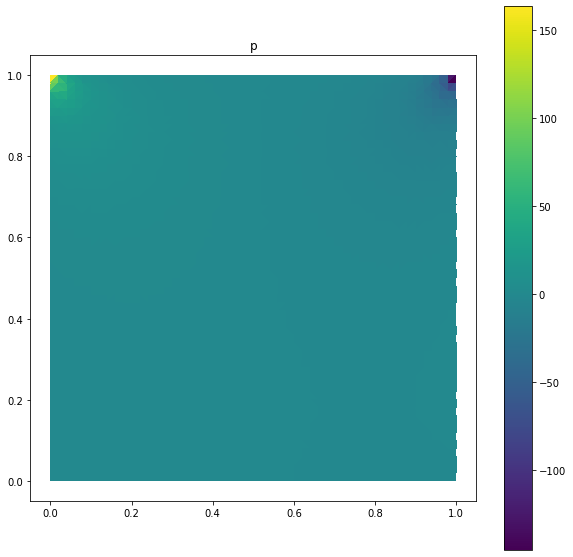

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
graph2D(
    fig=fig,
    lists=[[pS, ax, 'p']],
    natural_show=True,     # points_on=True,
    )

In [8]:
try:
    shutil.rmtree(save_dir)
except:
    print('Directory empty yet')

with io.XDMFFile(
    domain.comm, save_dir+'/velocity.xdmf', 'w'
    ) as file:
    file.write_mesh(domain)
    file.write_function(uS)

with io.XDMFFile(
    domain.comm, save_dir+'/pressure.xdmf', 'w'
    ) as file:
    file.write_mesh(domain)
    file.write_function(pS)

Directory empty yet
